-----------------------------------------

# Détectez des faux billets

### Lutte contre la criminalité organisée Algorithme de détection de faux billets

Définition: Le faux-monnayage est la contrefaçon de monnaie et sur le plan légal et judiciaire, l’infraction consistant à fabriquer, à détenir ou à utiliser de la fausse monnaie.

### Scénario :

Société de consulting informatique, un nouveau contrat au Ministère de l'Intérieur a été remporté. Cette nouvelle mission intervient dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage. La mission est d'intérêt public, élaborer un algorithme de détection de faux billets. Un seul mot d'ordre : Traquer la moindre fraude!

### Les données de la Police Judiciaire :

La PJ a transmis un jeu de données contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

la longueur du billet (en mm);

la hauteur du billet (mesurée sur le côté gauche, en mm);

la hauteur du billet (mesurée sur le côté droit, en mm);

la marge entre le bord supérieur du billet et l'image de celui-ci (en mm);

la marge entre le bord inférieur du billet et l'image de celui-ci (en mm);

la diagonale du billet (en mm).

In [219]:
#Import des principales librairies Python
# Manipulation des données
import pandas as pd
import seaborn as sns
# Graphiques
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Statistiques
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Description du jeu de données

Une première analyse est nécessaire pour pouvoir se faire une idée plus précise des données que nous avons à disposition.

A l'exception de la variable booléenne 'is_genuine', les 6 autres variables sont quantitatives continues. 

In [220]:
data_billet = pd.read_csv('notes')
data_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [221]:
data_billet.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87
169,False,171.96,104.00,103.95,5.63,3.26,110.96


# Analyse des variables

In [222]:
#Recherche de valeur(s) manquante(s)
data_billet.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool

le jeu de données n'a pas de valeur manquante, la fonction .isna().any() ne renvoie aucun "True".

In [223]:
#Recherche de doublons 
data_billet.duplicated().sum()

0

Le jeu de données n'a pas de doublon, la fonction .duplicated().sum() ne renvoie aucune valeur.

In [224]:
#Recherche de valeur(s) négative(s) 
display(data_billet[data_billet<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Le jeu de données n'a aucune valeur négative.

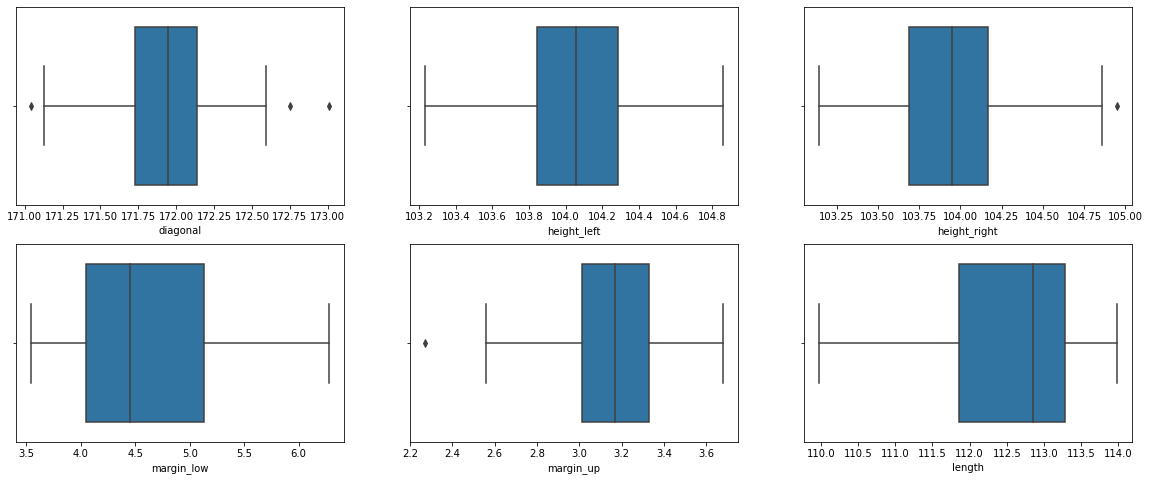

In [225]:
# Representation graphique des outliers:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation

fig = plt.figure(figsize=(20,8))

for i in data_billet.loc[:, data_billet.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    #plt.title('{} (boxplot)'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x = data_billet[i])
    c = c + 1
plt.savefig("Representation graphique des outliers",dpi=100)
plt.show()

A partir des Boxplots ci-dessus on peut identifier quelques outliers, mais sans prendre en compte la nature du billet (Vrai/Faux).\ Essayons l'approche Boxplot par variable selon la nature du billet.

In [226]:
#Représentation des effectifs par type de billet vrai/faux(méthode utilisée .value_counts())
effectif = data_billet['is_genuine'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['is_genuine']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(data_billet) #len(data) renvoie la taille de l'échantillon
tab

,is_genuine,n,f
0,True,100,0.588235
1,False,70,0.411765


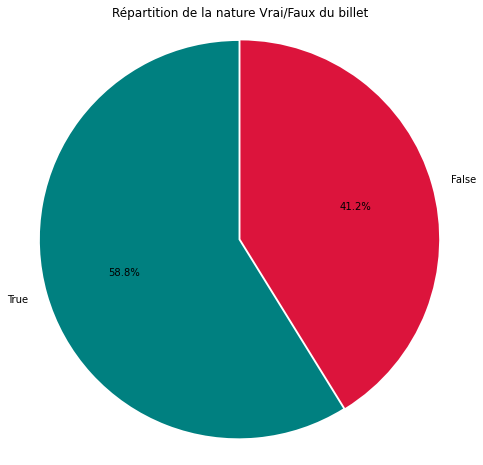

In [227]:
#Création d'un Pie Chart pour représenter la part de chaque type de billet
labels = 'True', 'False'
sizes = tab['f']
explode = (0.01, 0)

fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, explode=explode, labels=labels, colors=['teal','crimson'], 
        autopct='%1.1f%%', shadow=False, startangle=90)

ax.axis('equal') 
plt.title('Répartition de la nature Vrai/Faux du billet')

plt.savefig("Répartition de la nature Vrai ou Faux du billet",dpi=100)

plt.show()

In [228]:
#Taille du jeu de données
data_billet.shape

(170, 7)

In [229]:
#Valeurs descriptives des variables quantitatives
data_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


Ce tableau permet d'avoir une première idée des données que nous avons. Synthétique et très rapide à établir, c'est un point d'entré pertinent avant de pouvoir mieux connaître les variables et individus de l'échantillon.

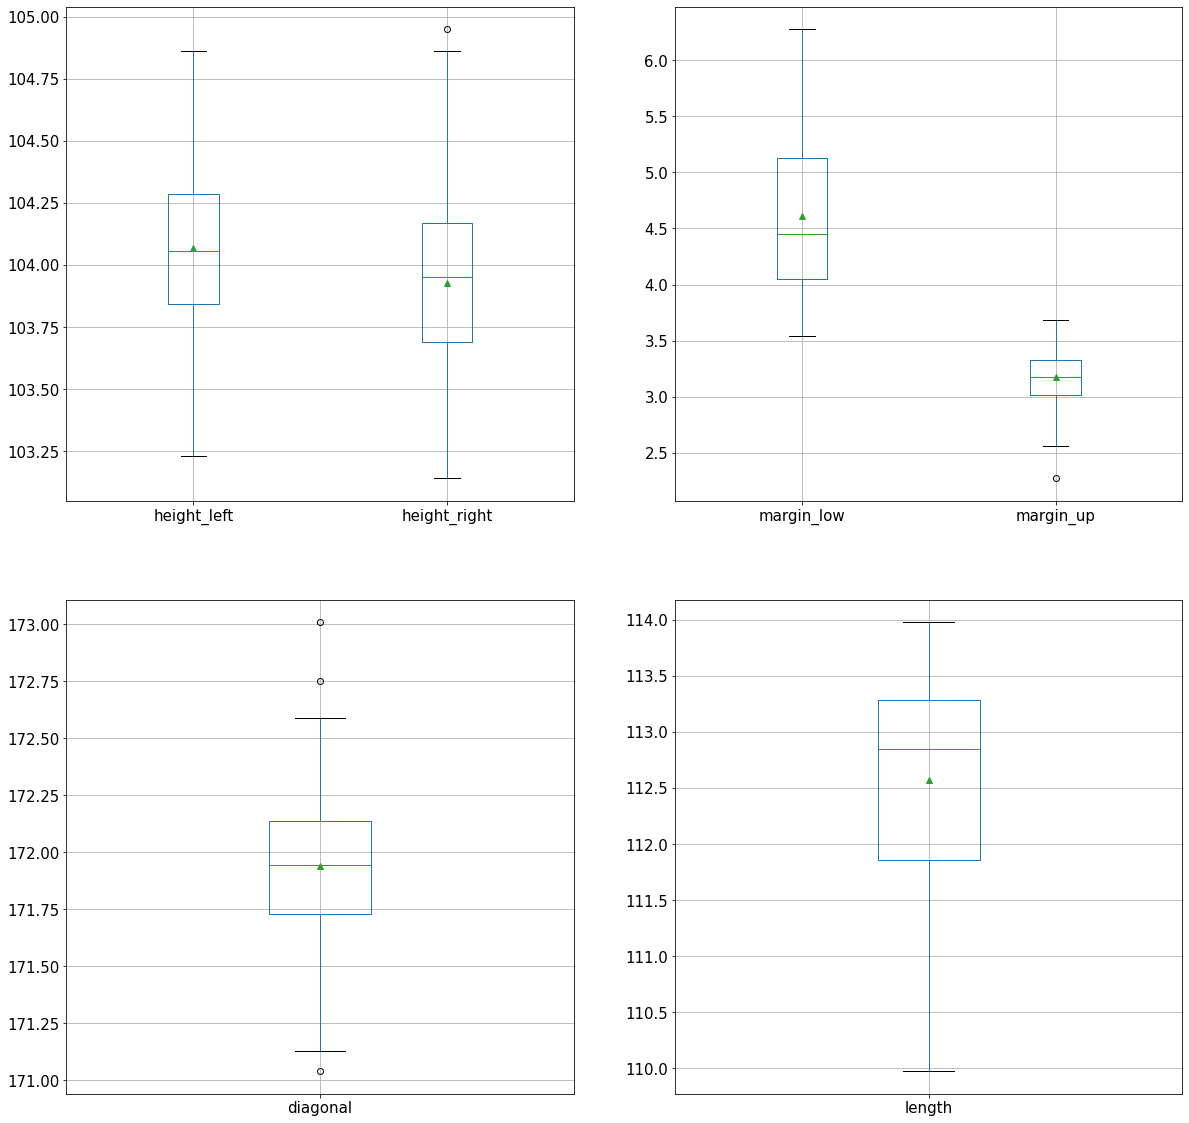

In [230]:
#Approche / identification visuelle par Boxplot de la distribution des variables et des éventuels outliers
plt.figure(figsize=(20, 20))
plt.title('Boxplot billet sans distinction vrai/faux')

plt.subplot(221)
data_billet.iloc[:, 2:4].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(222)
data_billet.iloc[:, 4:6].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(223)
data_billet.iloc[:, 1:2].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(224)
data_billet.iloc[:, -1:].boxplot(fontsize=15, widths=0.2, showmeans=True)

plt.savefig("Boxplot billet sans distinction vrai ou faux",dpi=100)

plt.show()

Des outliers sont visibles, mais restent relativement proches des queues de distribution. Ces valeurs restent totalement acceptables, elles ne semblent pas représenter d'erreur particulière. Ces outliers seront conservés pour la suite de l'analyse.

### Comparaison de la distribution des variables selon la nature des billets

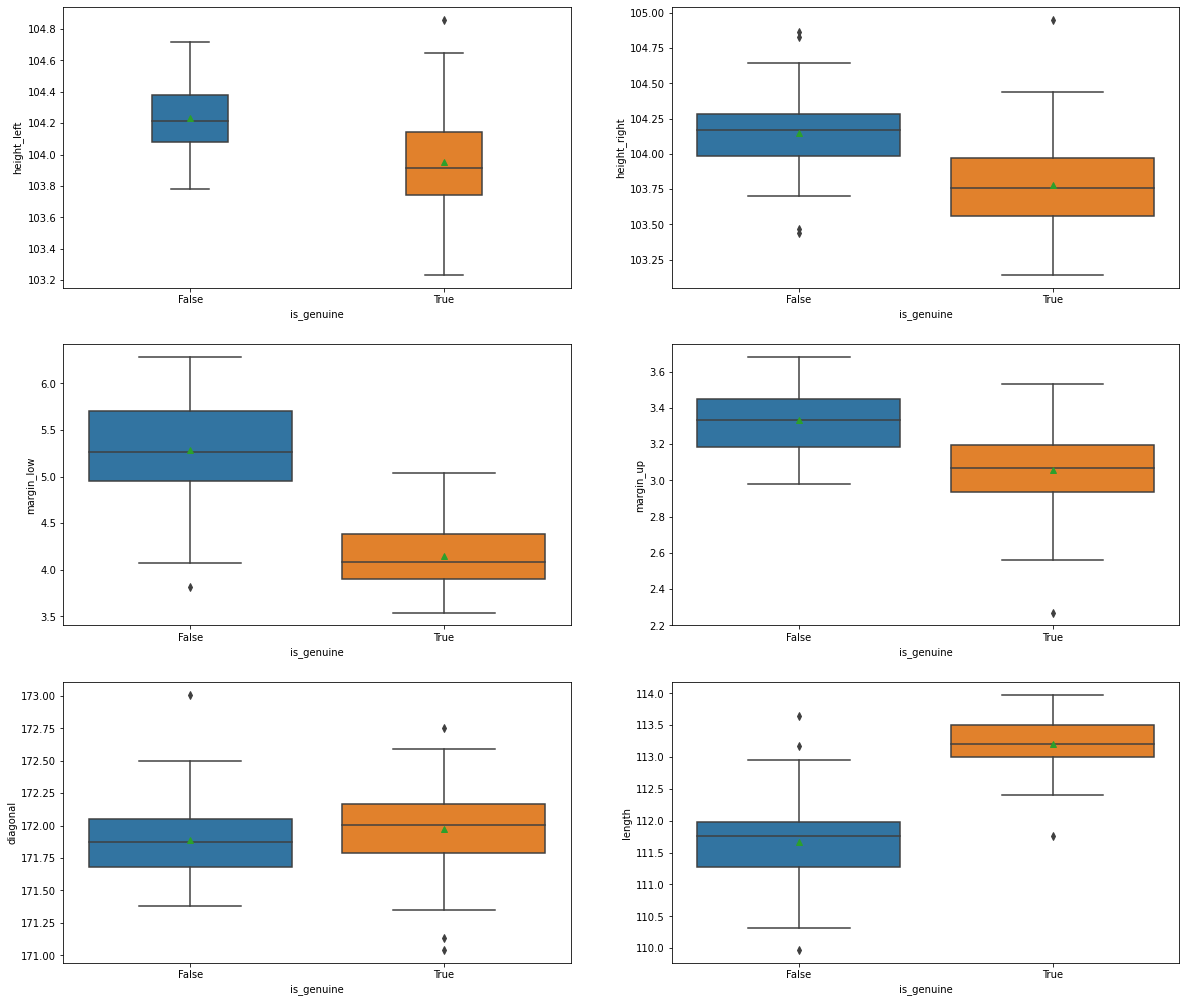

In [231]:
plt.figure(figsize=(20, 30))

plt.subplot(521)
sns.boxplot(x='is_genuine', y='height_left', width=0.3, data=data_billet, showmeans=True)
plt.subplot(522)
sns.boxplot(x='is_genuine', y='height_right', data=data_billet, showmeans=True)
plt.subplot(523)
sns.boxplot(x='is_genuine', y='margin_low', data=data_billet, showmeans=True)
plt.subplot(524)
sns.boxplot(x='is_genuine', y='margin_up', data=data_billet, showmeans=True)
plt.subplot(525)
sns.boxplot(x='is_genuine', y='diagonal', data=data_billet, showmeans=True)
plt.subplot(526)
sns.boxplot(x='is_genuine', y='length', data=data_billet, showmeans=True)

plt.savefig("Comparaison de la distribution des variables selon la nature des billets",dpi=100)
plt.show()

Un premier constat peut-être fait :

les métriques 'margin' et 'height' ont des moyennes et médianes plus élevées pour les faux billets.

la métrique 'length' a une moyenne et médiane plus basse pour les faux billets.

la métrique 'diagonal' ne semble pas être significative.



In [232]:
#Matrice des corrélations linéaires par l'utilisation de la méthode .corr()
data_billet.iloc[:, 1:].corr()

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


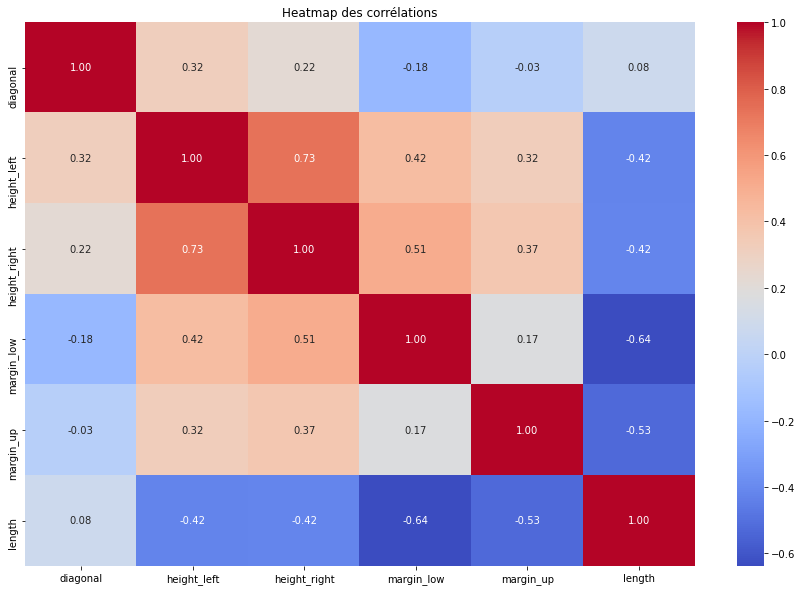

In [233]:
#HeatMap des corrélations linéaires à partir de la matrice précédente
plt.figure(figsize=(15, 10))
sns.heatmap(data_billet.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap des corrélations')

plt.savefig("HeatMap des corrélations linéaires",dpi=100)
plt.show()

Des corrélations linéaires existent entre certaines de nos variables, voyons plus en détails…

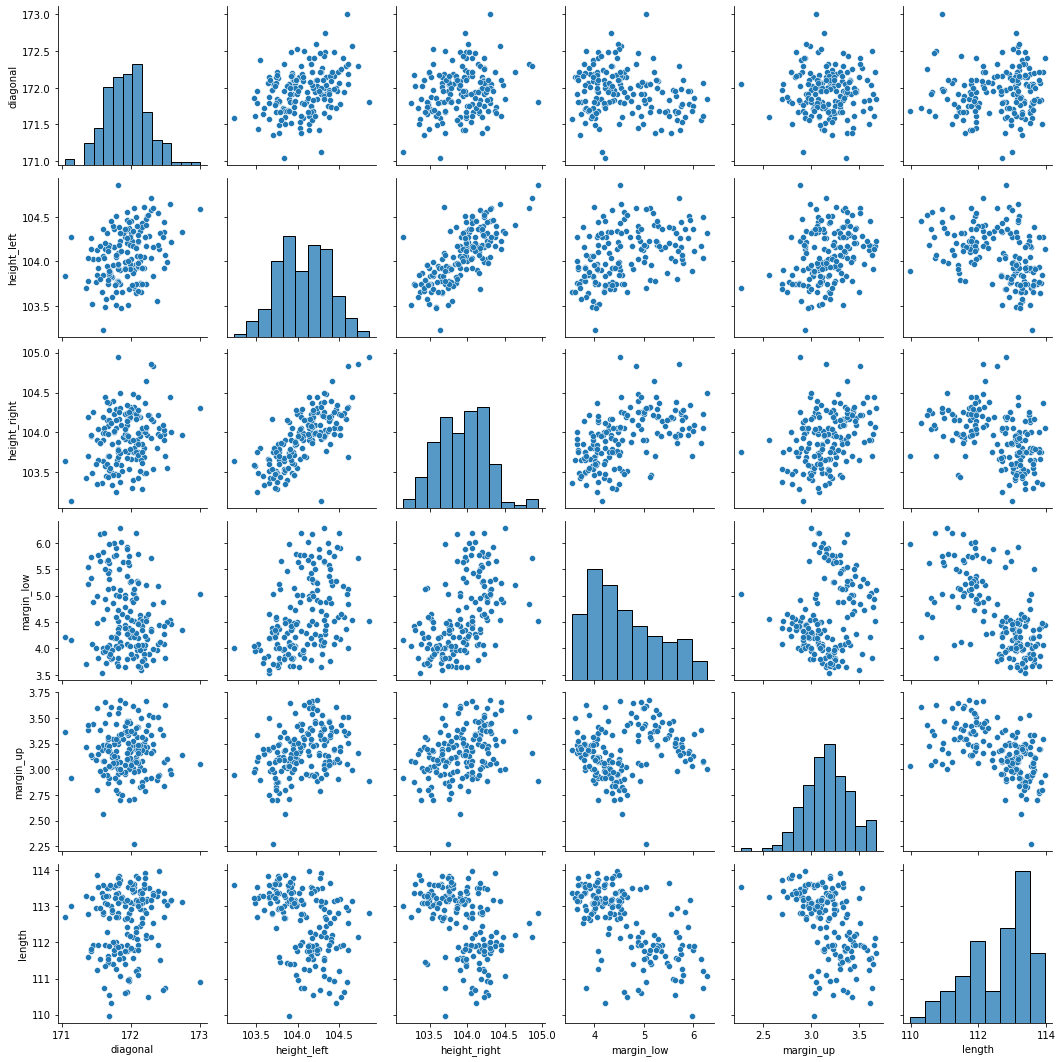

In [234]:
#Visualisation exploratoire des 6 variables quantitatives
#.pairplot une méthode de Seaborn simple et rapide pour se faire une idée visuelle des corrélations ou non
sns.pairplot(data_billet.iloc[:, 1:])
plt.savefig("Visualisation exploratoire des 6 variables quantitatives.png",dpi=100)
plt.show()

Certains points paraissent particulièrement éloignés de leurs groupes

Il ressort une corrélation linéaire entre les deux variables 'height_left' et 'height_right', le coefficient de pearson sera calculé pour vérifier l'observation.

In [235]:
#Coefficient de corrélation linéaire de Pearson entre 'height_left' et 'height_right'
coef_height = st.pearsonr(data_billet['height_right'], data_billet['height_left'])[0]
coef_height

0.7343902682297871

La valeur obtenue est proche de 1, il existe donc une réelle corrélation linéaire entre ces deux variables. Concrètement, au plus 'height_left' aura une valeur élevée, au plus 'height_right' le sera aussi.

In [236]:
#Coefficient de corrélation linéaire de Pearson entre 'length' et 'margin_low'
coef_length_margin = st.pearsonr(data_billet['length'], data_billet['margin_low'])[0]
coef_length_margin

-0.6373516884716645

La valeur obtenue est proche de -1, il existe donc une corrélation linéaire négative entre ces deux variables.

# Analyse en composantes principales de l'échantillon, en suivant les étapes ci-dessous

Analyse de l'éboulis des valeurs propres,

Représentation des variables par le cercle des corrélations,

Représentation des individus par les plans factoriels,

Analyse de la qualité de représentation et la contribution des individus.

In [237]:
#Préparation du jeu de données pour l'ACP
data_ACP = data_billet.copy()
data_ACP.index = data_ACP['is_genuine']
del data_ACP['is_genuine']

In [238]:
#Transformation des données en array Numpy
X = data_ACP.values

In [239]:
#Centrage/réduction des données (éviter les écarts d'échelle, les données prendront toutes la même importance)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [240]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\mzami\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['logistic', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


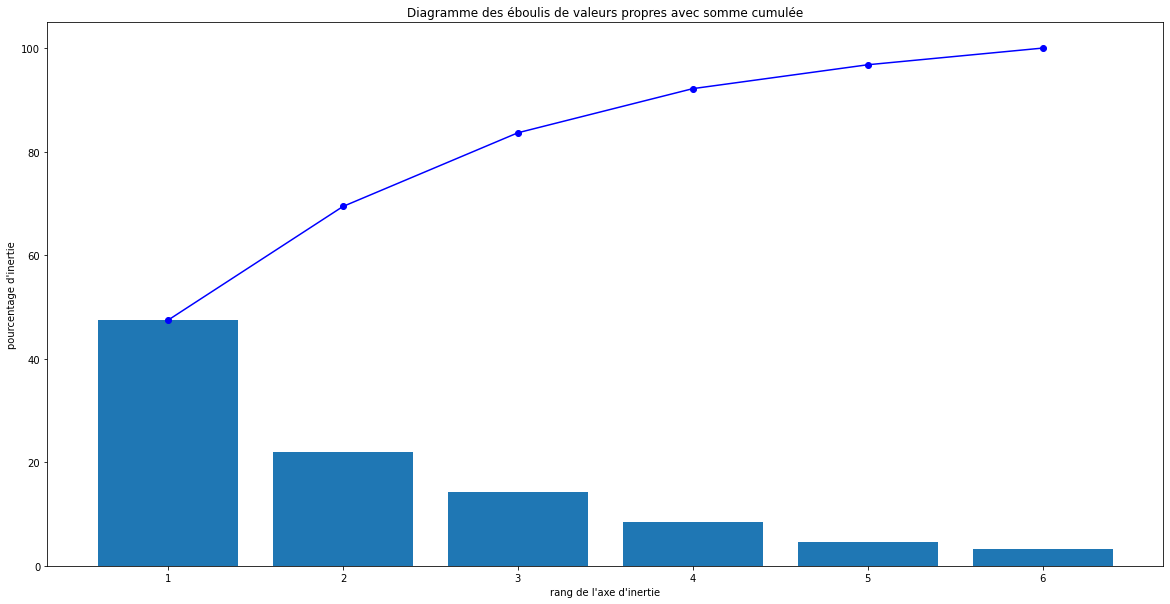

In [241]:
#Représentation de la variance expliquée: Diagramme des éboulis de valeurs propres avec somme cumulée
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100


plt.figure(figsize(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="blue",marker='o')
    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Diagramme des éboulis de valeurs propres avec somme cumulée")

plt.savefig("Diagramme des éboulis de valeurs propres avec somme cumulée",dpi=100)
plt.show()

La méthode du coude précise une représentation satisfaisante de nos variables sur les deux premières composantes principales, le premier axe factoriel.

In [242]:
#Calcul des composantes principales sur les deux premières
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [243]:
#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print(pca.explained_variance_ratio_.cumsum())

[0.47447921 0.69405027]


69% de la variance des données est expliquée par les deux premières composantes. L'analyse sera traitée ainsi, car l'ajout d'autres composantes n'apporte pas réellement de valeur ajoutée, du moins pas dans notre contexte actuel.

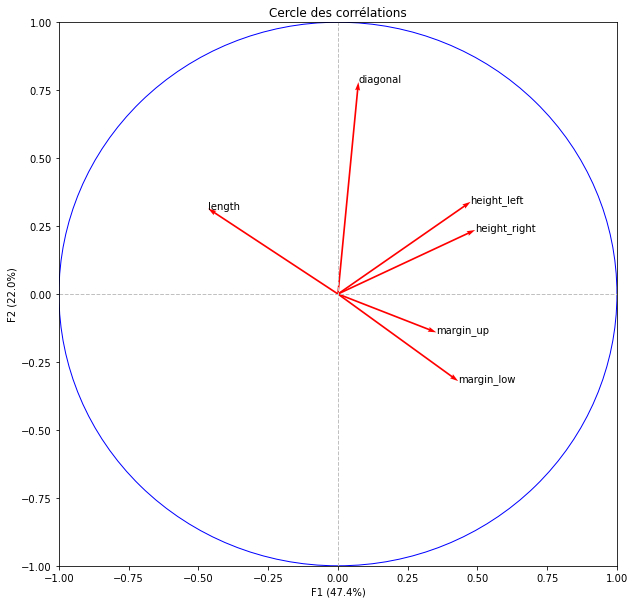

In [244]:
#Cercle des corrélations des variables
pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, data_ACP.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations')
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.savefig("Cercle des corrélations des variables",dpi=100)

plt.show()

A partir de cette représentation graphique, nous pouvons déterminer les variables qui se révélent être les plus corrélées aux composantes F1 et F2. Notons également que la longueur des flèches est importante, une variable dont la longueur de la flèche est proche de 1 sera extrêmement bien représentée.

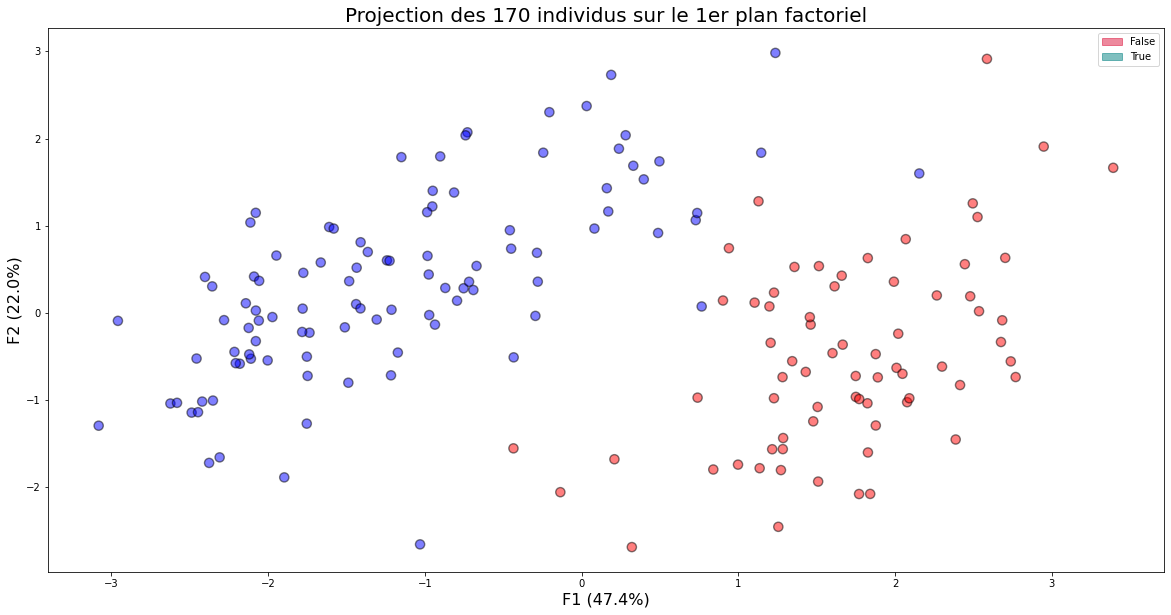

In [245]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))

#Projection des individus par scatter Plot sur le premier plan factoriel
colors = ['red', 'blue']
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data_billet['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

#Labels de la nature des billets
lab_0 = mpatches.Patch(color='crimson', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='teal', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=16)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=16)
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

plt.savefig("Projection des individus sur le 1er plan factoriel",dpi=100)
plt.show()

In [246]:
#Coefficients de la composante principale F1
F1 = pca.components_[0]
print(F1) 
#Coefficients de la composante principale F2
F2 = pca.components_[1]
print(F2)

[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
[ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]


#### Interprétation des projections réalisées : \ F1 : représente la longueur du billet / hauteur ainsi que la marge \ F2 : représente la longueur de la diagonale



L'axe de la première composante est celui qui sépare principalement les vrais billets des faux billets. De plus, F1 explique 47% de l'inertie. Sur la plupart des observations F1 permet l'identification des billets. Concernant les valeurs proches de zéro, c'est F2 qui permet de discriminer.

Le second axe explique 22% de l'inertie et participe à la séparation des vrais billets et des faux billets.

On voit qu'une diagonale sépare clairement les vrais et les faux billets.

In [247]:
#Calcul des composantes principales
#Ici seulement F1 et F2 seront utiles à l'interprétation attendue

data_fact = pd.DataFrame(X_projected, index=data_billet.index, columns=["F" + str(i+1) for i in range(2)]).iloc[:, :2]
data_fact

,F1,F2
0,2.153639,1.599709
1,-2.110416,-0.526039
2,-1.973152,-0.048102
3,-2.059795,-0.089105
4,-2.403180,0.412170
...,...,...
165,2.478626,0.189974
166,2.585331,2.914472
167,2.067245,0.845602
168,0.739257,-0.972965


## Contribution des individus dans l'inertie totale:

In [248]:
#Contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
con_ind_inertie = pd.DataFrame({'c_inertie':di, 'is_genuine':data_ACP.index})
con_ind_inertie

,c_inertie,is_genuine
0,18.410598,True
1,5.444799,True
2,4.960527,True
3,4.805719,True
4,18.039567,True
...,...,...
165,7.673233,False
166,20.625650,False
167,8.567410,False
168,3.482926,False


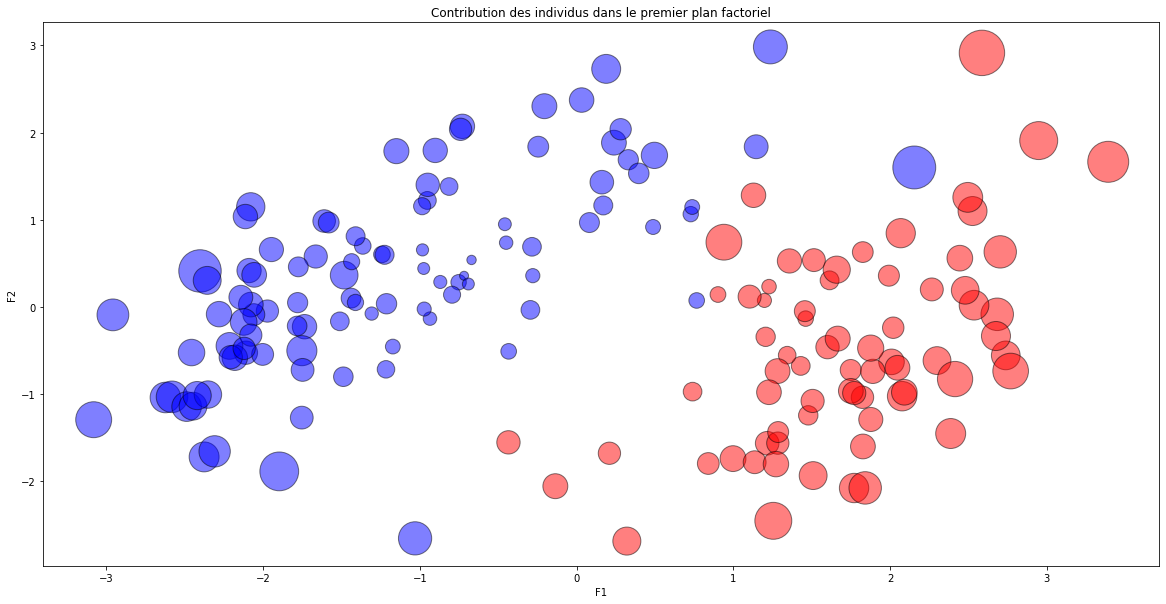

In [249]:
#Scatter Plot de la contribution des individus dans l'inertie totale
color = ['crimson', 'teal']
plt.scatter(data_fact['F1'], data_fact['F2'], c=data_billet['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1,
            s=con_ind_inertie['c_inertie']*100)

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Contribution des individus dans le premier plan factoriel')

plt.savefig("Contribution des individus dans le premier plan factoriel",dpi=100)
plt.show()

Il est judicieux de remarquer, du moins de prêter attention aux points dont la contribution est supérieure à la moyenne, car se sont des individus qui permettent de donner un sens à l’axe. De plus, une contribution trop importante d’un des points à un axe doit être regardé avec prudence (~25% d’inertie).

### Qualité de réprésentation des individus (COS2):

In [250]:
#Qualité de représentation des individus - COS2
cos2 = X_projected**2
n_comp = 2

for j in range(n_comp):
    cos2[:,j] = cos2[:,j]/di
    
cos2_individu = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1], 'is_genuine': data_billet['is_genuine']})
cos2_individu

,COS2_1,COS2_2,is_genuine
0,0.251929,0.139000,True
1,0.818002,0.050822,True
2,0.784862,0.000466,True
3,0.882856,0.001652,True
4,0.320145,0.009417,True
...,...,...,...
165,0.800651,0.004703,False
166,0.324059,0.411824,False
167,0.498809,0.083461,False
168,0.156908,0.271800,False


Lorsque l’angle est proche de 0, c'est-à-dire que le cosinus est proche de 1, l’individu est bien représenté. Dans le cas inverse, l’angle est proche de 90° et le cosinus est proche de 0.

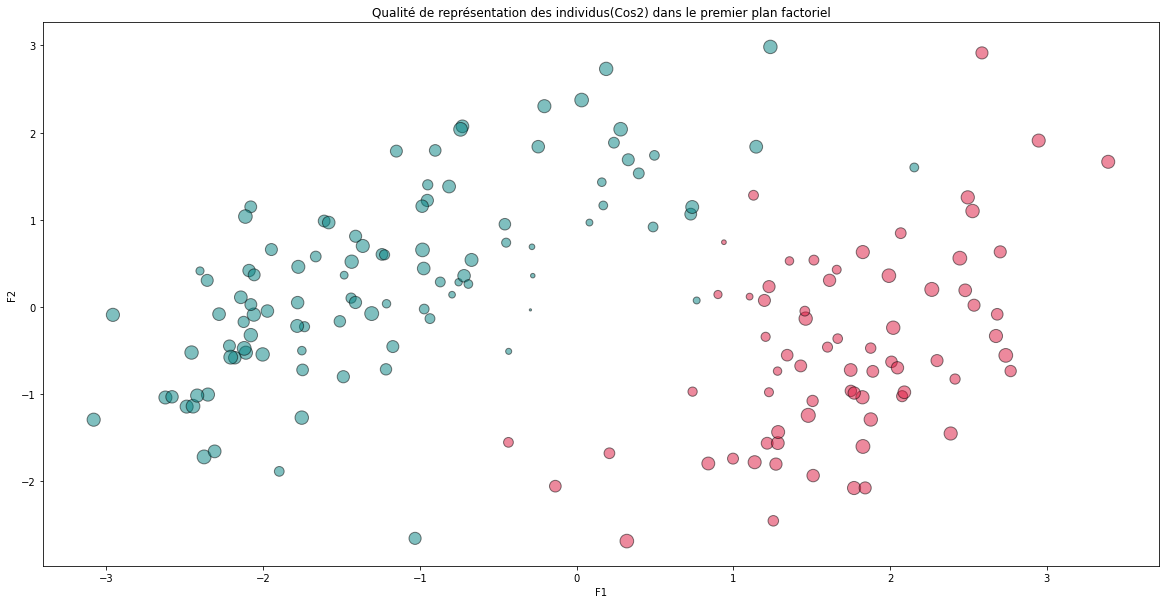

In [251]:
#Scatter Plot de la qualité de représentation des individus dans le 1er plan factoriel
cos2_individu['COS2_1 + COS2_2'] = cos2_individu['COS2_1'] + cos2_individu['COS2_2']
colors = ['crimson', 'teal']
plt.scatter(data_fact['F1'], data_fact['F2'], c=data_billet['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1,
            s=cos2_individu['COS2_1 + COS2_2']*200)

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Qualité de représentation des individus(Cos2) dans le premier plan factoriel')

plt.savefig("p6_graphic_qualite_representationcos2",dpi=100)
plt.show()

Ce scatter plot sur le premier plan factoriel nous démontre que les individus sont relativement très bien représentés. En effet, un individu mal représenté sera proche de l'origine, avec par conséquent peu de contribution à la formation des axes étudiés. Ici, ce n'est pas le cas, on distingue parfaitement deux groupes d'individus, avec un large espace proche de l'origine.

### Contribution des individus aux axes 

In [252]:
#Dimensions 
(n, p) = data_ACP.shape

#Calcul des valeurs propres à partir des valeurs singulières
eigval = pca.singular_values_**2/n

#Contribution aux axes
contr = X_projected**2
for j in range(2):
    contr[:,j] = contr[:,j]/(n*eigval[j])
    
contr_indiv = pd.DataFrame({'Billet':data_billet.index,'CTR_1':contr[:,0],'CTR_2':contr[:,1]})
contr_indiv

,Billet,CTR_1,CTR_2
0,0,0.009584,0.011426
1,1,0.009203,0.001236
2,2,0.008045,0.000010
3,3,0.008767,0.000035
4,4,0.011933,0.000759
...,...,...,...
165,165,0.012694,0.000161
166,166,0.013811,0.037927
167,167,0.008830,0.003193
168,168,0.001129,0.004227


On relève, pour chaque axe, quels sont les individus qui ont la plus forte contribution à la formation de l'axe. Il est désormais facile de pouvoir déterminer les individus dont la contribution est supérieure pour donner un sens aux axes.

# Classification par l'algorithme K-Means 

Utilisation du package «scikit-learn»

Une fois le clustering réalisé, les clusters seront visualisés dans le premier plan factoriel de l'ACP.

In [253]:
#Classification des individus par apprentissage non-supervisé K-Means en deux clusters 
cls = cluster.KMeans(n_clusters=2) 
cls.fit(X_scaled)

KMeans(n_clusters=2)

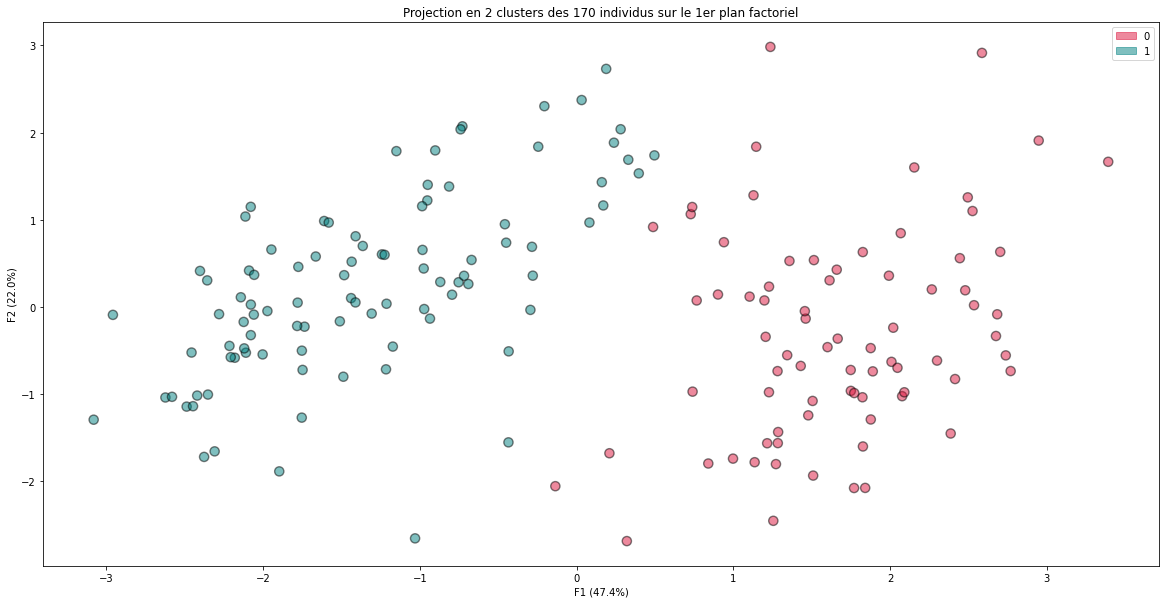

In [254]:
#Visualisation de nos deux clusters dans le premier plan factoriel

plt.figure(figsize=(20, 10))

categories = cls.labels_
colormap = np.array(['crimson', 'teal'])

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='crimson', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='teal', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("p6_graphic_projection_kmeans",dpi=100)
plt.show()

Plus de 69% de la variance des données est expliquée par les deux premières composantes, ce qui est plutôt pas mal. L'avantage du K-Means est d'obtenir directement des données centrées/réduites facilitant l'interprétation. Voyons ci-dessous les centroïdes des deux clusters pour chacune des 6 variables.

In [255]:
#Tableau des Centroïdes 2 clusters dans sa version centrée réduite
#La comparaison est tout de suite simplifiée, les dimensions prenant la même importance!
centroids = cls.cluster_centers_
pd.DataFrame(centroids, columns=data_ACP.columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.079185,0.645141,0.718611,0.840166,0.630841,-0.902645
1,0.064022,-0.521604,-0.581005,-0.679283,-0.510041,0.729798


In [256]:
#Intégration des clusters dans notre dataframe "df_cls" par la méthode .concat()
data_cls = pd.DataFrame(cls.fit_predict(X), columns=['cluster'])
data_cls = pd.concat([data_cls, data_billet], axis=1)
data_cls.head()

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.67,103.74,103.70,4.01,2.87,113.29
2,0,True,171.83,103.76,103.76,4.40,2.88,113.84
3,0,True,171.80,103.78,103.65,3.73,3.12,113.63
4,0,True,172.05,103.70,103.75,5.04,2.27,113.55


In [257]:
#Tableau des correspondances clusters/nature billets
tableau = pd.crosstab(cls.labels_,data_cls['is_genuine'])
tableau.index = ['Cluster 0 - Faux','Cluster 1 - True']
tableau.columns = ['Faux','Vrais']
tableau

,Faux,Vrais
Cluster 0 - Faux,2,99
Cluster 1 - True,68,1


Le clustering apporte une classification des billets en fonction des caractéristiques quantitatives. Il est aussi intéressant de pouvoir utiliser les centroïdes pour se faire une idée complémentaire à celle déjà faite à partir des cercles des corrélations, mais aussi à partir des premiers boxplots établis en début d'analyse.

Concrètement, il ressort toujours des significations entre la nature des billets et les variables 'margin' et 'height', dont les centroïdes sont positifs pour les faux billets, tandis que 'length' sera négatif pour les faux billets.

In [258]:
data_cls.to_csv("data.csv",index = False)

# Régression logistique:

### Modélisation des données à l'aide d'une Régression Logistique

Dans cette dernière phase de l'analyse, il sera question d'élaborer un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [259]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [260]:
data_cls.head()

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.67,103.74,103.70,4.01,2.87,113.29
2,0,True,171.83,103.76,103.76,4.40,2.88,113.84
3,0,True,171.80,103.78,103.65,3.73,3.12,113.63
4,0,True,172.05,103.70,103.75,5.04,2.27,113.55


In [261]:
#Préparation des données
X = data_cls.copy()
X = X.iloc[:, 2:]
y = data_cls.iloc[:, 0]

In [262]:
#Séparation entre les données d'entrainement et les données test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [263]:
X_train

,diagonal,height_left,height_right,margin_low,margin_up,length
85,172.10,103.95,103.72,4.49,3.07,113.15
133,171.69,104.17,104.37,5.31,3.54,111.89
127,172.40,104.55,104.22,5.18,3.51,111.94
123,172.05,104.60,104.32,5.12,3.35,111.78
135,171.86,104.12,104.10,6.01,3.34,111.91
...,...,...,...,...,...,...
149,171.91,103.91,103.98,4.78,3.65,111.41
101,171.97,104.38,104.18,5.59,3.47,110.98
150,171.95,104.26,103.97,5.88,3.16,112.44
9,172.14,104.34,104.20,4.63,3.02,112.47


In [264]:
y_train

85     0
133    1
127    1
123    1
135    1
      ..
149    1
101    1
150    1
9      0
79     0
Name: cluster, Length: 136, dtype: int32

In [265]:
data_cls.iloc[51]

cluster              0
is_genuine        True
diagonal        172.22
height_left     104.48
height_right    104.06
margin_low        4.59
margin_up         2.91
length          112.82
Name: 51, dtype: object

Ici, l'ensemble de données est divisé en deux parties dans un rapport de 20/80. Cela signifie que 80% des données seront utilisées pour la formation des modèles et 20% pour les tests des modèles. Les données étant assez limitées, le choix des 20% pour les données de test est choisi.

In [266]:
#Instanciation d'un modèle nommé lr
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [267]:
from sklearn.linear_model import LogisticRegression
X = data_cls.drop(['is_genuine'], axis=1).values
y = data_cls['is_genuine']

logistic = LogisticRegression()
logistic.fit(X,y)

LogisticRegression()

### Vérification de la colinéarité des variables

A partir du VIF (Variance Inflation Factor), le facteur d'influence de la variable, nous pouvons avoir une idée des éventuels problèmes de colinéarité.

In [268]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

reg_multi = smf.ols('diagonal ~ height_left + height_right + margin_low + margin_up + length', data=data_billet).fit()
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[2.249831212995871,
 2.5637087947433295,
 2.172802257913991,
 1.6252305296552272,
 2.463836435483419]

VIF < 10 il n'y aura pas d'influence liée à la colinéarité des variables. Si des variables colinéaires sont de facto fortement corrélées entre elles, deux variables corrélées ne sont pas forcément colinéaires. La régression logistique peut-être modélisée sur nos six variables explicatives, il ne semble pas avoir de frein possible, ni colinéarité, il n'y a non plus pas de valeur atypique influente.

### Évaluation du modèle à l'aide de la matrice de confusion.

Une matrice de confusion est un tableau utilisé pour évaluer les performances d'un modèle de classification. A l'aide de cette matrice il sera simple et rapide d'appréhender la pertinence du modèle élaboré. Le principe fondamental d'une matrice de confusion est le nombre de prédictions correctes et incorrectes qui sont résumées par classe.

In [269]:
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) 

[[22  0]
 [ 1 11]]


les coefficients sur la diagonale indiquent les éléments bien classés, les coefficients en dehors indiquent ceux que le classifieur a mis dans la mauvaise classe.

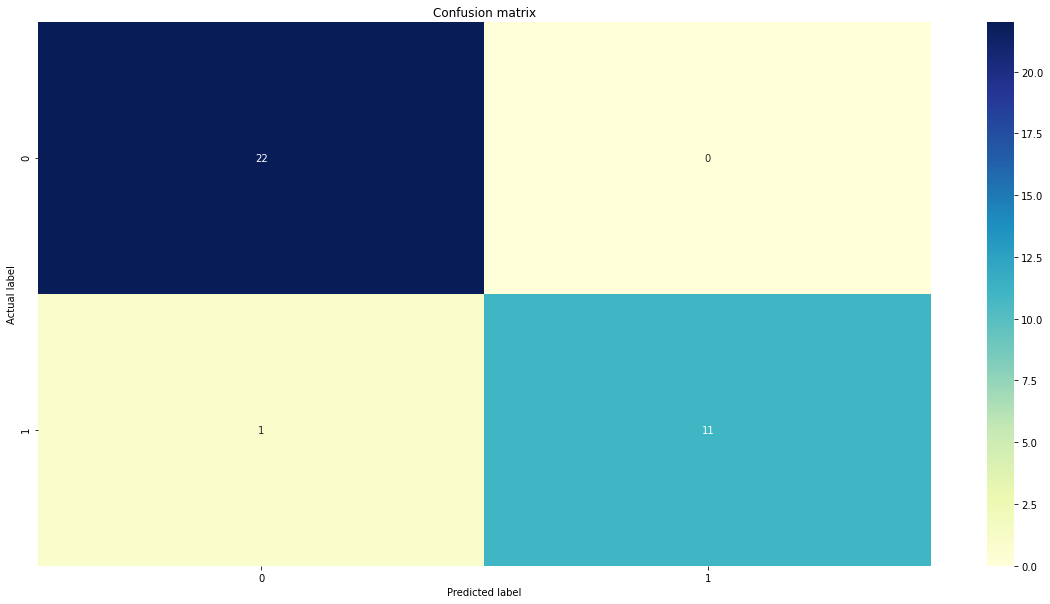

In [270]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.savefig("confision matrix",dpi=100)
plt.show()

## L'évaluation du modèle peut aussi se faire par la courbe ROC et sa métrique AUC.

La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décision. L'aire sous la courbe ROC, l'AUC (Area Under the ROC ), est une mesure de la qualité de la classification qui varie entre 0.5 dans le pire des cas et 1 dans le meilleur des cas.

In [271]:
#Récupération de la prédiction de la valeur positive
y_prob = lr.predict_proba(X_test)[:,1] 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

In [272]:
#Mesure AUC (Area Under the Curve): Aire sous la courbe
from sklearn import metrics
metrics.auc(false_positive_rate, true_positive_rate)

0.9962121212121212

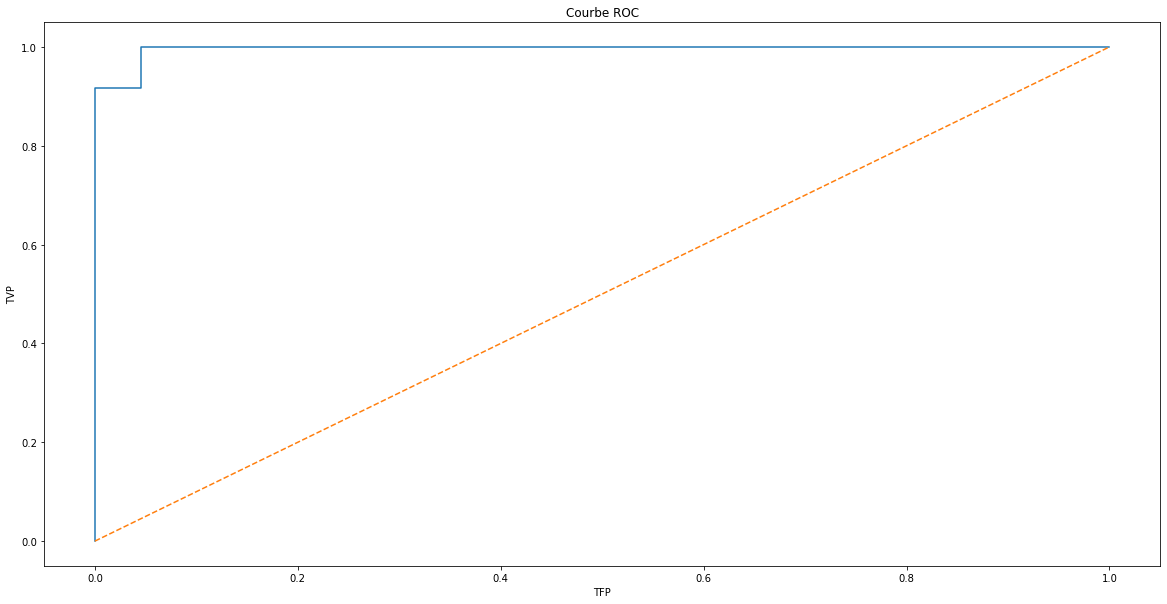

In [273]:
#Courbe ROC
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('TFP')
plt.ylabel('TVP')
plt.title('Courbe ROC')

plt.savefig("courbeROC",dpi=100)
plt.show()

L’idée de la courbe ROC est de faire varier le «seuil» de 1 à 0 et, pour chaque cas, calculer le taux de vrai positif et de faux positif que l’on reporte dans un graphique: en abscisse le TFP, en ordonnée le TVP.

Facile à interpréter, ne nécessite pas de mise à l'échelle, ni de calcul complexe. La régression logistique fournit un score de probabilité pour les observations. Dans ce cas précis, nous sommes très proche du classifieur optimal.

In [274]:
#Autres métriques d'évaluation du modèle 
print('  - Accuracy:' +str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)), '%')
print('  - Precision:' +str(round(metrics.precision_score(y_test, y_pred)*100, 2)), '%')
print('  - Recall:' +str(round(metrics.recall_score(y_test, y_pred)*100, 2)), '%')
print('  - F1 score:' +str(round(metrics.f1_score(y_test, y_pred)*100, 2)), '%')

  - Accuracy:97.06 %
  - Precision:100.0 %
  - Recall:91.67 %
  - F1 score:95.65 %


## Application sur le fichier test_exemple.csv

Le modèle 'lr' étant validé, des prédictions peuvent-être menées sur d'autres jeux de données, essayons avec le second fichier que nous avons à disposition.

In [275]:
#Prédiction faite à partir du fichier "test_example.csv"
data_test = pd.read_csv('test_notes (1).csv')
data_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [276]:
# Données pour la prédiction
X_a_predire = data_test.iloc[:, 0:6]
# Prédiction avec notre modèle.
y_pred = lr.predict(X_a_predire)
print(y_pred)
proba_true = lr.predict_proba(X_a_predire)[:, 1]
print(proba_true)
# Ajout d'une colonne avec la pobabilité que le sample soit vrai selon la prédiction
data_test["proba_veridique"] = np.round(proba_true, 2)
# Ajout d'une colonne avec la prédiction
data_test["prediction_veridique"] = y_pred

[0 1 0 1 1]
[0.03304319 0.91198091 0.00549214 0.99495085 0.89968106]


In [ ]:
# Données pour la prédiction
X_a_predire = data_final.iloc[:, 0:6]
# Prédiction avec notre modèle.
y_pred = lr.predict(X_a_predire)
proba_true = lr.predict_proba(X_a_predire)[:, 1]
# Ajout d'une colonne avec la pobabilité que le sample soit vrai selon la prédiction
data_final["proba_veridique"] = np.round(proba_true, 2)
# Ajout d'une colonne avec la prédiction
data_final["prediction_veridique"] = y_pred

In [277]:
data_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_veridique,prediction_veridique
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.03,0
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.91,1
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.01,0
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.99,1
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.90,1


In [278]:
#Résultats de la classification prédictive :
resultat = []
for i in data_test['prediction_veridique'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

data_test['resultat'] = resultat
data_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_veridique,prediction_veridique,resultat
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.03,0,Faux Billet
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.91,1,Vrai Billet
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.01,0,Faux Billet
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.99,1,Vrai Billet
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.90,1,Vrai Billet


Dataframe final avec résultats des classifications:\ Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.